In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from HOTRG import get_lattice_size,get_dist_torus_2D,get_dist_2D
import matplotlib as mpl
import importlib
import correlation_ansatzs
importlib.reload(correlation_ansatzs)
from correlation_ansatzs import high_temp_correlation,low_temp_correlation,low_temp_correlation_1,low_temp_correlation_2,critical_correlation,loglog

%matplotlib inline

def process_data(filename,log2Size=30):
    data=pd.read_pickle(filename)
    lattice_size=get_lattice_size(nLayers=2*log2Size,spacial_dim=2)
    data['x']=data.apply(lambda row:row['x1']-row['x0'],axis=1)
    data['y']=data.apply(lambda row:row['y1']-row['y0'],axis=1)
    data['dist']=data.apply(lambda row:get_dist_torus_2D(row['x'],row['y'],lattice_size),axis=1)
    data['theta']=data.apply(lambda row:np.arctan2(row['y'],row['x']),axis=1)
    data=data.sort_values(by=['dist'])
    return data


def fitWithHuberLoss(ansatz,x,y,p0=None,epsilon=1,
                             allow_positive_outliers=True,allow_negative_outliers=True):
    def loss(xs,ys,*p):
        dist=ys-ansatz(xs,*p)
        loss1=1/2 * dist**2 # lsq
        loss2=epsilon*(np.abs(dist)-epsilon/2) # huber
        if allow_positive_outliers:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative_outliers:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1)
    xfit,yfit=x,y
    res=minimize(lambda p: loss(xfit,yfit,*p),p0,method='Nelder-Mead',tol=1e-6)
    p=res.x
    return p


def fit_data(data,ansatz,name='correlation',cutoff=1e-2):
    data_slice=data[(data[name]>=cutoff)].sort_values('dist')
    assert len(data_slice)>0,'no data above cutoff'
    logx,logy=np.log(data_slice['dist']),np.log(data_slice[name])
    p,cov=curve_fit(loglog(ansatz),logx,logy,p0=ansatz.p0,maxfev=10000)
    p=fitWithHuberLoss(loglog(ansatz),logx,logy,p0=p,epsilon=0.1)
    cov=None
    print('fitted parameters:',p)
    print('fitted equation:',ansatz.eq.format(*p))
    return p,cov,ansatz

[GILT] Warning! float32 is not precise enough, leads to bad RG behavior
[GILT] Warning! float32 is not precise enough, leads to bad RG behavior


/home/wenhan/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


fitted parameters: [1.95987836e-08 1.71859234e-01]
fitted equation: 1.96e-08x^(-2 Δ),Δ=0.1719
fitted parameters: [3.55039169e-11 7.90633070e-02]
fitted equation: 3.55e-11x^(-2 Δ),Δ=0.0791
fitted parameters: [1.21271725e-11 5.66456255e-02]
fitted equation: 1.21e-11x^(-2 Δ),Δ=0.0566
fitted parameters: [2.39864419e-08 1.78903650e-01]
fitted equation: 2.40e-08x^(-2 Δ),Δ=0.1789


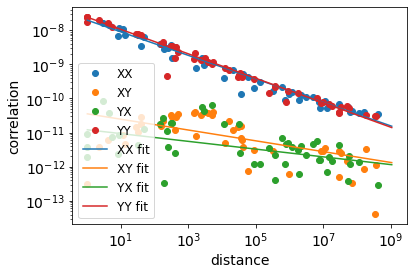

In [4]:
def combine_data(datas,names):
    all_data=datas[0].copy()
    for name,data in zip(names,datas):
        assert all(data[x].equals(all_data[x]) for x in ['x0','x1','y0','y1'])
        all_data[name]=data['correlation']
    all_data=all_data.drop(columns=[x for x in all_data.columns if x.startswith('op')]+['correlation'])
    return all_data

folder_name='data/akltStrange_X24/a1_0.0001225_a2_0.0002449'
data1=process_data(folder_name+'/correlation_XX.pkl',log2Size=30)
data2=process_data(folder_name+'/correlation_XY.pkl',log2Size=30)
data3=process_data(folder_name+'/correlation_YX.pkl',log2Size=30)
data4=process_data(folder_name+'/correlation_YY.pkl',log2Size=30)

data=combine_data([data1,data2,data3,data4],['XX','XY','YX','YY'])
del data1,data2,data3,data4



p1,cov1,ansatz1=fit_data(data,critical_correlation,name='XX',cutoff=0)
p2,cov2,ansatz2=fit_data(data,critical_correlation,name='XY',cutoff=0)
p3,cov3,ansatz3=fit_data(data,critical_correlation,name='YX',cutoff=0)
p4,cov4,ansatz4=fit_data(data,critical_correlation,name='YY',cutoff=0)

ls=np.geomspace(1,2**30)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.plot(data['dist'],data['XX'],'o',label='XX',c='C0')
plt.plot(data['dist'],data['XY'],'o',label='XY',c='C1')
plt.plot(data['dist'],data['YX'],'o',label='YX',c='C2')
plt.plot(data['dist'],data['YY'],'o',label='YY',c='C3')

plt.plot(ls,critical_correlation(ls,*p1),label='XX fit',c='C0')
plt.plot(ls,critical_correlation(ls,*p2),label='XY fit',color='C1')
plt.plot(ls,critical_correlation(ls,*p3),label='YX fit',color='C2')
plt.plot(ls,critical_correlation(ls,*p4),label='YY fit',color='C3')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
# plt.ylim([1e-6,1])
plt.legend()
plt.show()

